In [1]:
!pip install -q yfinance

Epoch 1, Train Loss: 7.0617
Epoch 2, Train Loss: 5.4714
Epoch 3, Train Loss: 5.3874
Epoch 4, Train Loss: 5.3582
Epoch 5, Train Loss: 5.2979
Date: 2024-02-01 00:00:00-05:00
Ticker: AAPL, Next Day Pct Change: -0.0054, Predicted Score: 0.5223
Ticker: NVDA, Next Day Pct Change: 0.0497, Predicted Score: 0.5169
Ticker: MSFT, Next Day Pct Change: 0.0184, Predicted Score: 0.5183
Ticker: AMZN, Next Day Pct Change: 0.0787, Predicted Score: 0.5167
Ticker: GOOGL, Next Day Pct Change: 0.0086, Predicted Score: 0.5183
Ticker: META, Next Day Pct Change: 0.2032, Predicted Score: 0.5162
Ticker: TSLA, Next Day Pct Change: -0.0050, Predicted Score: 0.5224
Ticker: TSM, Next Day Pct Change: 0.0208, Predicted Score: 0.5148
Ticker: LLY, Next Day Pct Change: 0.0109, Predicted Score: 0.5156
Ticker: V, Next Day Pct Change: 0.0005, Predicted Score: 0.5178
Ticker: PG, Next Day Pct Change: -0.0068, Predicted Score: 0.5155
Ticker: JNJ, Next Day Pct Change: -0.0111, Predicted Score: 0.5243
Ticker: UNH, Next Day Pct C

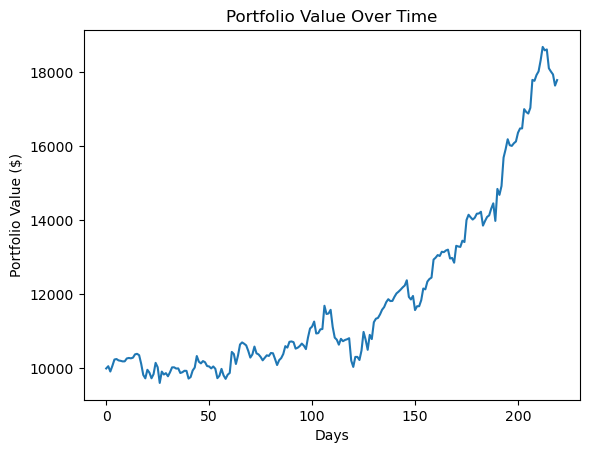

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Fetch stock data from yfinance
def fetch_stock_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)
        if not df.empty:
            df['Pct_Change'] = df['Close'].pct_change()
            df['Next_Pct_Change'] = df['Pct_Change'].shift(-1)  # Next day's pct change
            data[ticker] = df.dropna()  # Remove rows with NaN
    return data

# Dataset for stock trading
class StockTradingDataset(Dataset):
    def __init__(self, stock_data, seq_len):
        self.data = []
        self.seq_len = seq_len
        self.scaler = MinMaxScaler()

        for ticker, df in stock_data.items():
            features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Pct_Change']].values
            features = self.scaler.fit_transform(features)  # Normalize features
            for i in range(len(features) - seq_len - 1):
                x = features[i:i + seq_len, :-1]  # Input features
                y = features[i + seq_len, -1]    # Target (Pct_Change)
                self.data.append((x, y))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Transformer model
class StockSelectorTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, ff_dim, output_dim, max_len, dropout=0.1):
        super(StockSelectorTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(self._generate_positional_encoding(max_len, embed_dim), requires_grad=False)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, output_dim)

    def _generate_positional_encoding(self, seq_len, embed_dim):
        position = torch.arange(0, seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(torch.log(torch.tensor(10000.0)) / embed_dim))
        pe = torch.zeros(seq_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)
        x += self.positional_encoding[:, :seq_len, :]
        x = x.permute(1, 0, 2)
        x = self.encoder(x)
        x = x.mean(dim=0)
        scores = self.fc(x)
        return scores

# Simulate single-stock trading
def simulate_single_stock_trading(model, stock_data, seq_len, start_cash=10000):
    model.eval()
    cash = start_cash
    portfolio_value = start_cash
    held_stock = None  # Current held stock (ticker)
    num_shares = 0
    daily_values = []  # Track daily portfolio values

    # Add predicted scores to each stock's data
    for ticker, df in stock_data.items():
        df['Predicted_Score'] = np.nan
        features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Pct_Change']].values
        scaler = MinMaxScaler()
        features = scaler.fit_transform(features)
        for i in range(seq_len, len(features)):
            x = torch.tensor(features[i - seq_len:i, :-1], dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                prediction = model(x).item()
            df.loc[df.index[i], 'Predicted_Score'] = prediction

    # Simulate trading day-by-day
    dates = stock_data[next(iter(stock_data))].index
    for date in dates[seq_len:]:
        print(f"Date: {date}")
        # Find the stock with the highest predicted score
        best_stock = None
        best_score = -float('inf')
        for ticker, df in stock_data.items():
            if date in df.index and not pd.isna(df.loc[date, 'Predicted_Score']):
                score = df.loc[date, 'Predicted_Score']
                next_pct_change = df.loc[date, 'Next_Pct_Change']
                print(f"Ticker: {ticker}, Next Day Pct Change: {next_pct_change:.4f}, Predicted Score: {score:.4f}")
                if score > best_score:
                    best_score = score
                    best_stock = ticker

        # Decide trading action
        if best_stock is None:
            daily_values.append(portfolio_value)
            continue

        current_price = stock_data[best_stock].loc[date, 'Close']

        if held_stock is None:
            num_shares = cash // current_price
            cash -= num_shares * current_price
            held_stock = best_stock
        elif held_stock != best_stock:
            cash += num_shares * stock_data[held_stock].loc[date, 'Close']
            num_shares = cash // current_price
            cash -= num_shares * current_price
            held_stock = best_stock

        portfolio_value = cash + (num_shares * current_price if held_stock else 0)
        daily_values.append(portfolio_value)

    # Calculate percentage return
    percentage_return = (portfolio_value - start_cash) / start_cash * 100
    print(f"Final Portfolio Value: ${portfolio_value:.2f}")
    print(f"Percentage Return: {percentage_return:.2f}%")

    # Plot portfolio value over time
    plt.plot(daily_values)
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Days")
    plt.ylabel("Portfolio Value ($)")
    plt.show()

    return percentage_return

# Main function
if __name__ == "__main__":
    tickers = [
        "AAPL", "NVDA", "MSFT", "AMZN", "GOOGL", "META", "TSLA", 
        "TSM", "LLY", "V", "PG", "JNJ", "UNH", "XOM", 
        "JPM", "WMT", "MA", "CVX", "HD"
    ]
    seq_len = 20

    # Fetch training data (2020-2023)
    train_stock_data = fetch_stock_data(tickers, "2020-01-01", "2023-12-31")

    # Fetch testing data (2024)
    test_stock_data = fetch_stock_data(tickers, "2024-01-01", "2024-12-31")

    # Create datasets and dataloaders
    train_dataset = StockTradingDataset(train_stock_data, seq_len)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Model parameters
    input_dim = 5
    embed_dim = 64
    num_heads = 4
    num_layers = 2
    ff_dim = 128
    output_dim = 1
    max_len = seq_len
    dropout = 0.1

    # Instantiate model
    model = StockSelectorTransformer(
        input_dim=input_dim,
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        ff_dim=ff_dim,
        output_dim=output_dim,
        max_len=max_len,
        dropout=dropout
    )

    # Training setup
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(5):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = criterion(predictions.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        print(f"Epoch {epoch + 1}, Train Loss: {total_train_loss:.4f}")

    # Simulate trading on test data (2024)
    simulate_single_stock_trading(model, test_stock_data, seq_len)
